<a href="https://colab.research.google.com/github/mukeshsharma1981/ML-Projects/blob/gh-pages/Covid_19_Cases_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install streamlit

I will start the task of Covid-19 cases prediction with Python for the next 30 days by importing the necessary Python libraries and the dataset:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from fbprophet import Prophet
from sklearn.metrics import r2_score

plt.style.use("ggplot")

df0 = pd.read_csv("/content/CONVENIENT_global_confirmed_cases.csv")
df1 = pd.read_csv("/content/CONVENIENT_global_deaths.csv")

**Data Preparation**
Now the next step is data preparation, I will simply prepare new data by combining the above datasets and then we will visualize a geographical plot of the data to see what we are going to work with:

In [4]:
world = pd.DataFrame({"Country":[],"Cases":[]})
world["Country"] = df0.iloc[:,1:].columns
cases = []
for i in world["Country"]:
    cases.append(pd.to_numeric(df0[i][1:]).sum())
world["Cases"]=cases

country_list=list(world["Country"].values)
idx = 0
for i in country_list:
    sayac = 0
    for j in i:
        if j==".":
            i = i[:sayac]
            country_list[idx]=i
        elif j=="(":
            i = i[:sayac-1]
            country_list[idx]=i
        else:
            sayac += 1
    idx += 1
world["Country"]=country_list
world = world.groupby("Country")["Cases"].sum().reset_index()
world.head()
continent=pd.read_csv("/content/continents2.csv")
continent["name"]=continent["name"].str.upper()

**Data Visualization**

Now here I will prepare three visualizations. One will be a geographical visualization to visualize the worldwide spread of Covid-19. Then the next visualization will be to have a look at the daily cases of Covid-19 in the world. Then the last visualization will be to have a look at the daily death cases of Covid-19 in the world.

Now let’s start data visualization by looking at the worldwide spread of Covid-19:

In [5]:
world["Cases Range"]=pd.cut(world["Cases"],[-150000,50000,200000,800000,1500000,15000000],labels=["U50K","50Kto200K","200Kto800K","800Kto1.5M","1.5M+"])
alpha =[]
for i in world["Country"].str.upper().values:
    if i == "BRUNEI":
        i="BRUNEI DARUSSALAM"
    elif  i=="US":
        i="UNITED STATES" 
    if len(continent[continent["name"]==i]["alpha-3"].values)==0:
        alpha.append(np.nan)
    else:
        alpha.append(continent[continent["name"]==i]["alpha-3"].values[0])
world["Alpha3"]=alpha

fig = px.choropleth(world.dropna(),
                   locations="Alpha3",
                   color="Cases Range",
                    projection="mercator",
                    color_discrete_sequence=["white","khaki","yellow","orange","red"])
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Now let’s have a look at the daily cases all around the world:

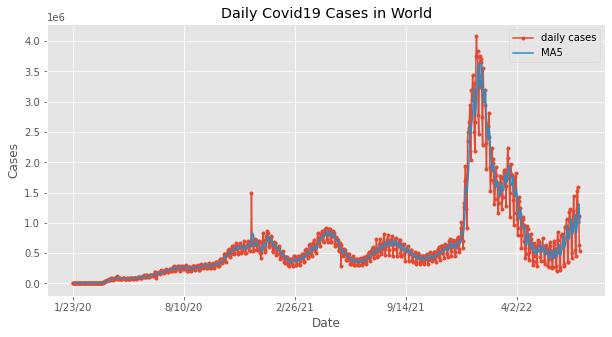

In [6]:
count = []
for i in range(1,len(df0)):
    count.append(sum(pd.to_numeric(df0.iloc[i,1:].values)))

df = pd.DataFrame()
df["Date"] = df0["Country/Region"][1:]
df["Cases"] = count
df=df.set_index("Date")

count = []
for i in range(1,len(df1)):
    count.append(sum(pd.to_numeric(df1.iloc[i,1:].values)))

df["Deaths"] = count

df.Cases.plot(title="Daily Covid19 Cases in World",marker=".",figsize=(10,5),label="daily cases")
df.Cases.rolling(window=5).mean().plot(figsize=(10,5),label="MA5")
plt.ylabel("Cases")
plt.legend()
plt.show()

Now let’s have a look at the daily death cases of Covid-19:

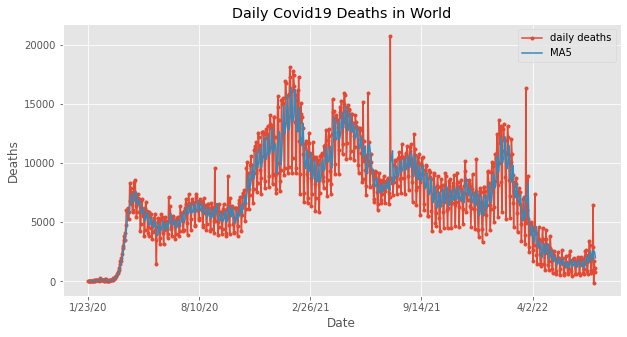

In [7]:
df.Deaths.plot(title="Daily Covid19 Deaths in World",marker=".",figsize=(10,5),label="daily deaths")
df.Deaths.rolling(window=5).mean().plot(figsize=(10,5),label="MA5")
plt.ylabel("Deaths")
plt.legend()
plt.show()

**Covid-19 Cases Prediction with Python for Next 30 Days**

Now, I will use the Facebook prophet model for the task of Covid-19 cases prediction with Python for the next 30 days. Facebook prophet model uses time series method for forecasting. 

Let’s see how we can use the Facebook prophet model for Covid-19 cases prediction with Python for the next 30 days:

Initial log joint probability = -14.2545
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1538.47     0.0380366       126.411       3.886      0.3886      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1593.64   8.19819e-05       70.9232           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       1599.13   0.000614799       124.044    4.89e-06       0.001      369  LS failed, Hessian reset 
     299       1599.76   0.000212995       80.4031           1           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1600.72    2.0176e-06       78.3953      0.5113      0.5113      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1601.16   0.000320939    

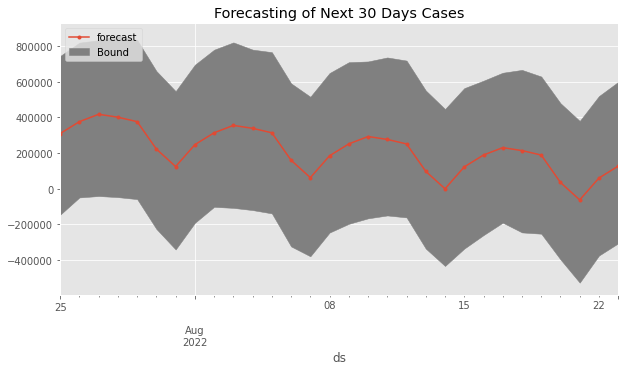

In [8]:
class Fbprophet(object):
    def fit(self,data):
        
        self.data  = data
        self.model = Prophet(weekly_seasonality=True,daily_seasonality=False,yearly_seasonality=False)
        self.model.fit(self.data)
    
    def forecast(self,periods,freq):
        
        self.future = self.model.make_future_dataframe(periods=periods,freq=freq)
        self.df_forecast = self.model.predict(self.future)
        
    def plot(self,xlabel="Years",ylabel="Values"):
        
        self.model.plot(self.df_forecast,xlabel=xlabel,ylabel=ylabel,figsize=(9,4))
        self.model.plot_components(self.df_forecast,figsize=(9,6))
        
    def R2(self):
        return r2_score(self.data.y, self.df_forecast.yhat[:len(df)])
        
df_fb  = pd.DataFrame({"ds":[],"y":[]})
df_fb["ds"] = pd.to_datetime(df.index)
df_fb["y"]  = df.iloc[:,0].values

model = Fbprophet()
model.fit(df_fb)
model.forecast(30,"D")
model.R2()

forecast = model.df_forecast[["ds","yhat_lower","yhat_upper","yhat"]].tail(30).reset_index().set_index("ds").drop("index",axis=1)
forecast["yhat"].plot(marker=".",figsize=(10,5))
plt.fill_between(x=forecast.index, y1=forecast["yhat_lower"], y2=forecast["yhat_upper"],color="gray")
plt.legend(["forecast","Bound"],loc="upper left")
plt.title("Forecasting of Next 30 Days Cases")
plt.show()